# Determine multi-agent plan conflict

In [1]:
import sys
sys.path.append('../')

sys.path.append('../../')

from panav.PBS.conflict import path_conflict

from panav.env import NavigationEnv, Box2DRegion, PolygonRegion, box_2d_center, line_seg_to_obstacle
from panav.viz import draw_env
from panav.SAMP import Tube_Planning
from panav.util import unique_tx, interpolate_positions


from panav.viz import animation
from IPython.display import HTML, display

import shapely
import numpy as np
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
# go_agent = 0
# yield_agent = 1

d = 2
K = 10
t0 = 0
vmax = 1.0

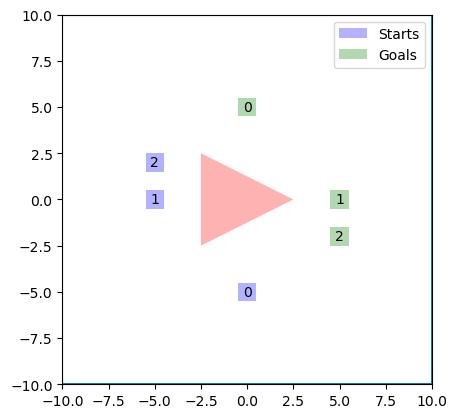

In [3]:

start_locs = np.array([[0,-5],[-5,0],[-5,2]])*1.0
goal_locs = np.array([[0,5],[5,0],[5,-2]])*1.0


start_box_side = np.array([1,1])
goal_box_side = np.array([1,1])

starts = [box_2d_center(s,start_box_side) for s in start_locs]

goals = [box_2d_center(g,goal_box_side) for g in goal_locs]

limits = [(-10.0,10.0),(-10.0,10.0)]

O1 = PolygonRegion([(-2.5,2.5),(-2.5,-2.5),(2.5,0)])

env = NavigationEnv(limits,[O1],starts,goals)

draw_env(env)

# Planning without conflict resolution

In [25]:
agents = set(np.arange(len(start_locs)))

plans = []
times = []

bloating_r = 0.5
d = 2
K = 10
t0 = 0
vmax = 1.0

for agent in agents:
    start = env.starts[agent]
    goal = env.goals[agent]

    t, xs = Tube_Planning(env,start,goal,vmax,bloating_r,\
                                 [],\
                                d,K,t0)

    t,xs = unique_tx(t,xs)
    plans.append(xs)
    times.append(t)

In [26]:
print('flowtime:', np.sum([t[-1] for t in times]))

flowtime: 40.90902781979312


In [27]:
def MA_plan_conflict(times,plans):
    for i in range(len(plans)):
        t,x=times[i],plans[i]
        for j in range(i+1,len(plans)):
            tp,xp = times[j],plans[j]
            if path_conflict(t,x,tp,xp,bloating_r,bloating_r):
                return True
    return False

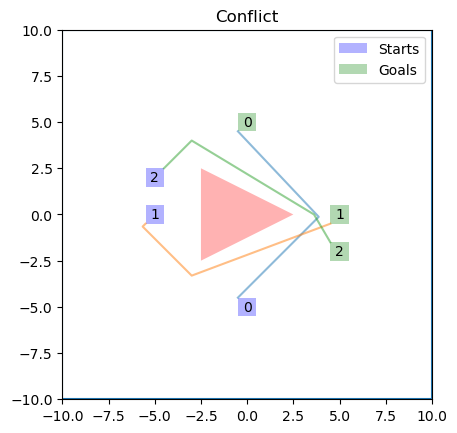

In [28]:
draw_env(env,plans)

plt.title('Conflict' if MA_plan_conflict(times,plans)
 else 'No Conflict')


plt.show()


# Planning with conflict resolution

In [29]:
plans = []
times = []
for agent in agents:
    start = env.starts[agent]
    goal = env.goals[agent]

    t, xs = Tube_Planning(env,start,goal,vmax,bloating_r,\
                                 [(a,b) for a,b in zip(times,plans)],\
                                d,K,t0)
    t,xs = unique_tx(t,xs)
    plans.append(xs)
    times.append(t)

In [30]:
print('flowtime:', np.sum([t[-1] for t in times]))

flowtime: 44.42388609942848


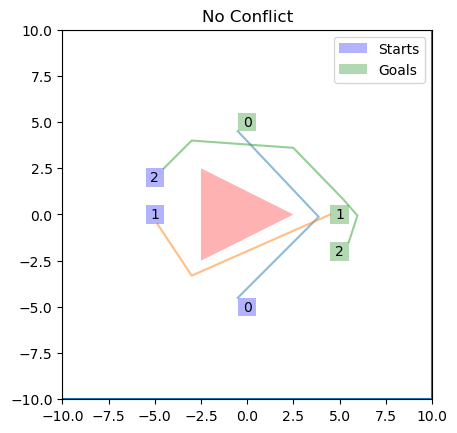

In [31]:
draw_env(env,plans)

plt.title('Conflict' if MA_plan_conflict(times,plans)
 else 'No Conflict')


plt.show()

## More challenging environment

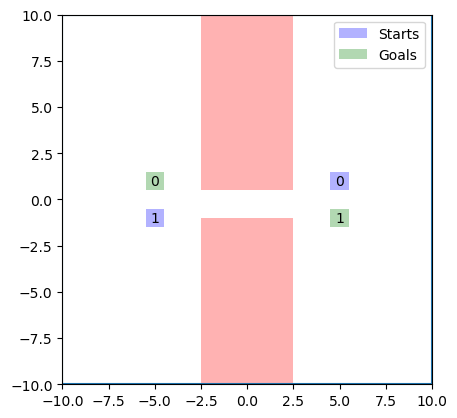

In [11]:

start_locs = np.array([[5,1],[-5,-1]])
goal_locs = np.array([[-5,1],[5,-1]])


start_box_side = np.array([1,1])
goal_box_side = np.array([1,1])

starts = [box_2d_center(s,start_box_side) for s in start_locs]

goals = [box_2d_center(g,goal_box_side) for g in goal_locs]

O1 = Box2DRegion((-2.5,2.5),(0.5,10))
O2 = Box2DRegion((-2.5,2.5),(-10,-1.0))

limits = [(-10.0,10.0),(-10.0,10.0)]

bloating_r = 0.5 

env = NavigationEnv(limits,[O1,O2],starts,goals)

draw_env(env)

### Planning without conflict resolution

In [12]:
start = env.starts[go_agent]
goal = env.goals[go_agent]
times,xs = Tube_Planning(env,start,goal,vmax,bloating_r,\
                                 [],\
                                d,K,t0)
times,xs = unique_tx(times,xs)


start = env.starts[yield_agent]
goal = env.goals[yield_agent]
t2,x2 = Tube_Planning(env,start,goal,vmax,bloating_r,\
                      [],\
                         d,K,t0)
t2,x2 = unique_tx(t2,x2)

In [13]:
print('flowtime:',t2[-1] + times[-1])

flowtime: 25.45584402409589


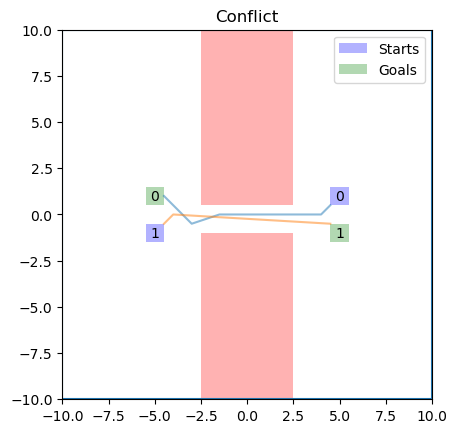

In [14]:

draw_env(env,[xs,x2])

plt.title('Conflict' if path_conflict(times,xs,t2,x2,bloating_r,bloating_r)
 else 'No Conflict')

plt.show()

In [15]:
interp_dt = 0.1
times,xs = interpolate_positions(times,xs,interp_dt)
t2,x2 = interpolate_positions(t2,x2,interp_dt)

pos = [xs,x2]
anim = animation(env, pos, bloating_r, dt = interp_dt / 4)
display(HTML(anim.to_jshtml()))
plt.close()   # Avoid plotting an extra figure.

### Planning with conflict resolution

In [16]:
# Planning for the agent with higher priority
start = env.starts[go_agent]
goal = env.goals[go_agent]
times,xs = Tube_Planning(env,start,goal,vmax,bloating_r,\
                                 [],\
                                d,K,t0)
times,xs = unique_tx(times,xs)

# Planning for the agent with lower priority
start = env.starts[yield_agent]
goal = env.goals[yield_agent]
t2,x2 = Tube_Planning(env,start,goal,vmax,bloating_r,\
                      [(times,xs)],\
                         d,4,t0) 
# By reducing the number of segments K, the number of integer variables will
# also reduce, which typically leads to more efficient solver performance.

In [17]:
print('flowtime:',t2[-1] + times[-1])

flowtime: 36.04138216985524


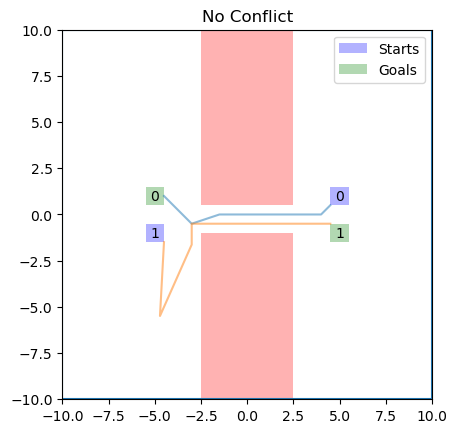

In [18]:

draw_env(env,[xs,x2])

plt.title('Conflict' if path_conflict(times,xs,t2,x2,bloating_r,bloating_r)
 else 'No Conflict')

plt.show()

In [19]:
times,xs = interpolate_positions(times,xs,interp_dt)
t2,x2 = interpolate_positions(t2,x2,interp_dt)

pos = [xs,x2]
anim = animation(env, pos, bloating_r, dt = interp_dt / 4)
display(HTML(anim.to_jshtml()))
plt.close()   # Avoid plotting an extra figure.